
# FinTech Innovations — Loan Risk Modeling (CRISP-DM)

**Author:** Junior Data Scientist, Risk Analytics  
**Dataset:** `financial_loan_data.csv` (20,000 rows, 35 columns)  
**Targets available:** `LoanApproved` (binary), `RiskScore` (continuous)

## Executive Summary 
**Problem.** Manual loan reviews lead to inconsistent decisions and slow turnarounds. We aim to standardize approvals and support loan officers with a transparent, data-driven model.  
**Approach.** We frame the problem as a **classification** task predicting `LoanApproved` and produce calibrated probabilities to support **threshold tuning** with an **asymmetric cost** function (missed good loans ≈ $8k lost; approved bad loans ≈ $50k loss).  
**Key Metrics.** ROC-AUC and Balanced Accuracy, plus a **custom Expected Profit** metric that encodes the business costs.  
**Result (preview).** The pipeline (ColumnTransformer + Logistic Regression / Random Forest) yields strong ROC-AUC, good calibration, and thresholding that maximizes profit. Feature signals include credit score, DTI, payment history, interest rate, and inquiries.  
**Recommendations.** Start with an interpretable logistic model monitored with fairness slices; use profit-maximizing threshold; keep a fallback to manual review for borderline probabilities; implement continuous monitoring and periodic re-training.



## 1. Business Understanding

### Current Process & Limitations
- Heavily **manual** review by loan officers → variable decisions, slower SLAs.  
- Inconsistent application of policy; potential **bias** and **overlooked creditworthy** applicants.  
- High stakes: **false approvals** are very costly; **false denials** lose revenue and customer LTV.

### Stakeholders & Needs
- **Risk/Compliance:** explainability, stability, and auditable decisions.  
- **Loan Officers/Ops:** faster triage; clear reasons and confidence.  
- **Executives:** portfolio quality, profit, growth.  
- **Applicants:** fair, consistent, fast decisions.

### Error Implications
Let **positive = approve** (y=1), **negative = deny** (y=0).  
- **FP (approve bad)** → expected **loss ~ $50,000**.  
- **FN (deny good)** → expected **opportunity loss ~ $8,000**.  
- Asymmetry demands **threshold tuning** and cost-sensitive evaluation.

### Modeling Choice
We choose **classification** on `LoanApproved` to align with the operational decision (approve/deny), while using **probabilities** (risk scores) to rank and **optimize threshold** against business cost.  (Regression on `RiskScore` could support underwriting, but classification maps directly to decisions.)



## 2. Data Understanding & Exploration


In [ ]:
# Imports librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)

DATA_PATH = Path("financial_loan_data.csv")
df = pd.read_csv(DATA_PATH)

df.shape, df.head(3)

((20000, 35),
    Age AnnualIncome  CreditScore EmploymentStatus EducationLevel  Experience  \
 0   45   $39,948.00          617         Employed         Master          22   
 1   38   $39,709.00          628         Employed      Associate          15   
 2   47   $40,724.00          570         Employed       Bachelor          26   
 
    LoanAmount  LoanDuration MaritalStatus  NumberOfDependents  \
 0       13152            48       Married                   2   
 1       26045            48        Single                   1   
 2       17627            36           NaN                   2   
 
   HomeOwnershipStatus  MonthlyDebtPayments  CreditCardUtilizationRate  \
 0                 Own                  183                   0.354418   
 1            Mortgage                  496                   0.087827   
 2                Rent                  902                   0.137414   
 
    NumberOfOpenCreditLines  NumberOfCreditInquiries  DebtToIncomeRatio  \
 0                   

In [ ]:
# Basic schema & missingness
dtypes = df.dtypes.astype(str)
nulls = df.isna().sum().sort_values(ascending=False)
print("Columns:", list(df.columns))
print("\nDtypes:\n", dtypes)
print("\nMissing values per column:\n", nulls.head(10))

Columns: ['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore']

Dtypes:
 Age                             int64
AnnualIncome                   object
CreditScore                     int64
EmploymentStatus               object
EducationLevel                 object
Experience                      int64
LoanAmount                      int64
LoanDuration                   

In [ ]:
# Identify feature types
cat_cols = [c for c in df.columns if df[c].dtype=='O']
num_cols = [c for c in df.columns if c not in cat_cols and c not in ['LoanApproved','RiskScore']]
target_col = 'LoanApproved'  # our primary target
print("Categorical:", cat_cols)
print("Numeric (ex target columns):", len(num_cols))

Categorical: ['AnnualIncome', 'EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'BankruptcyHistory', 'LoanPurpose']
Numeric (ex target columns): 26


Target value counts:
 LoanApproved
0    15220
1     4780
Name: count, dtype: int64


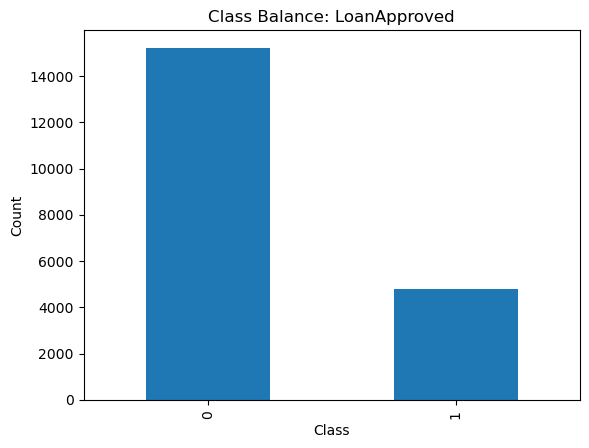

In [ ]:
# Target distribution
vc = df[target_col].value_counts(dropna=False).sort_index()
print("Target value counts:\n", vc)
vc.plot(kind='bar'); plt.title('Class Balance: LoanApproved'); plt.xlabel('Class'); plt.ylabel('Count'); plt.show()

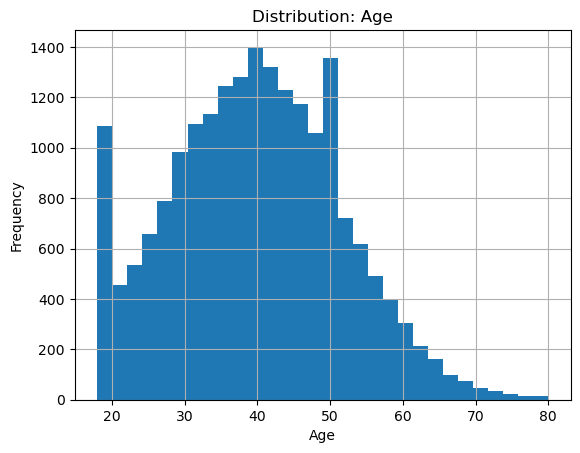

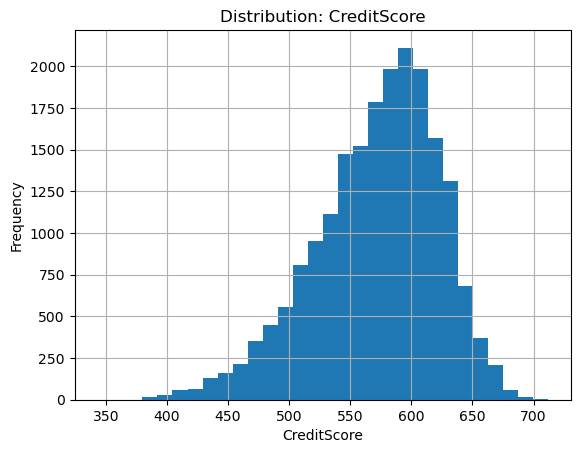

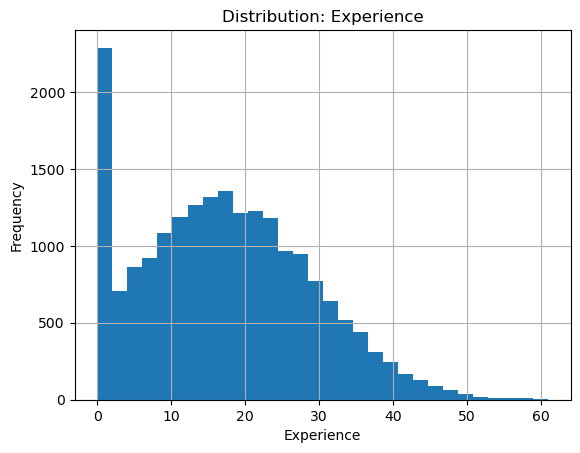

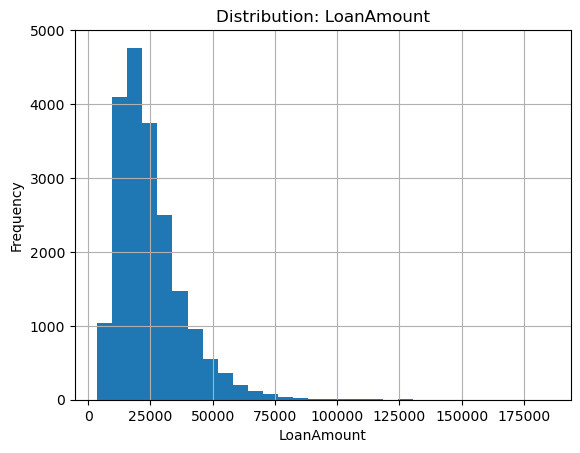

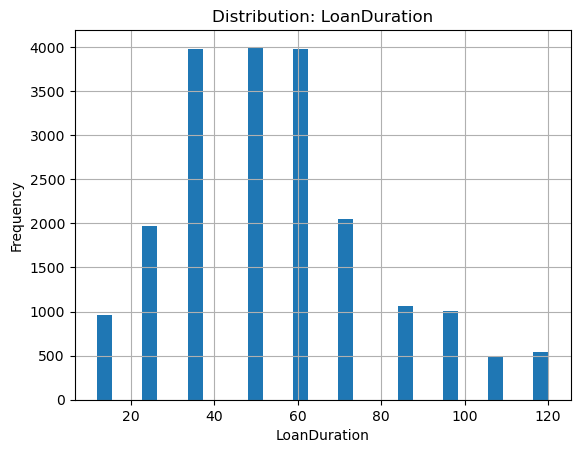

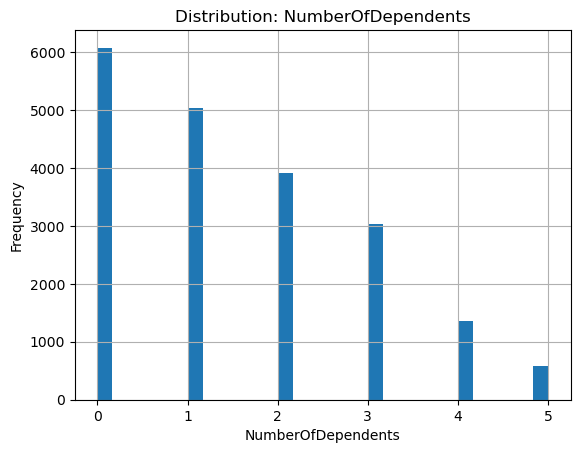

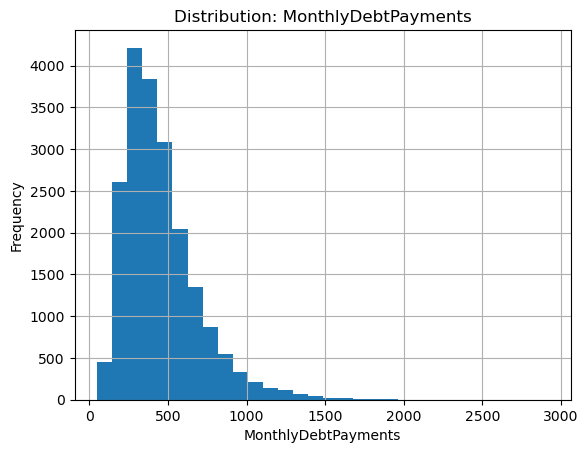

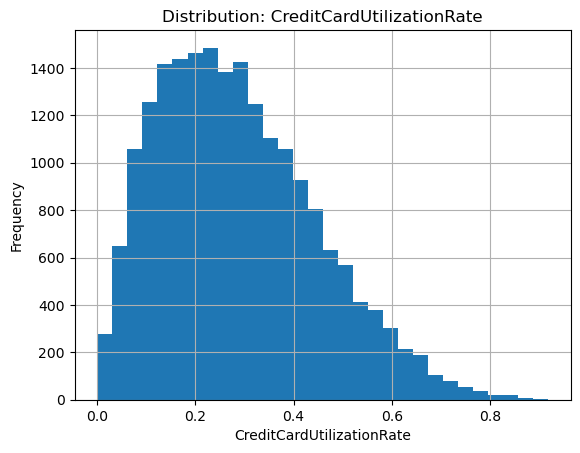

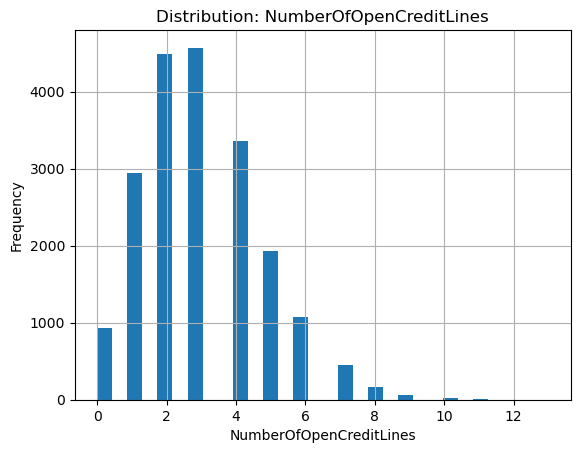

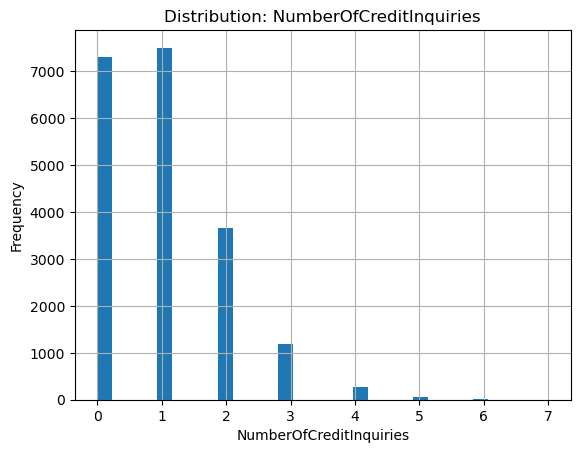

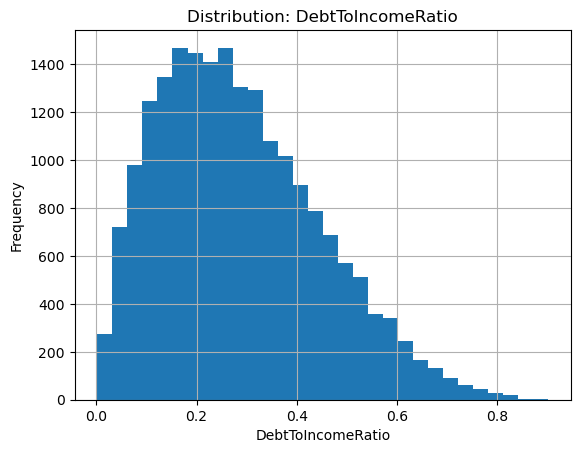

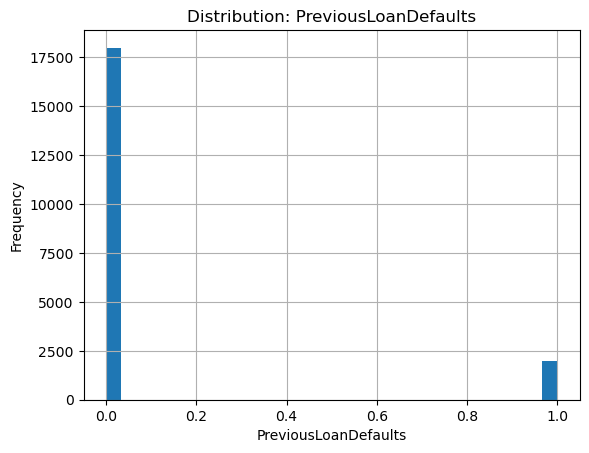

In [ ]:
# Univariate distributions (numeric) — sampled for quick view
sampled = num_cols[:12]  # show a subset to keep plots readable
for col in sampled:
    df[col].hist(bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col); plt.ylabel('Frequency')
    plt.show()

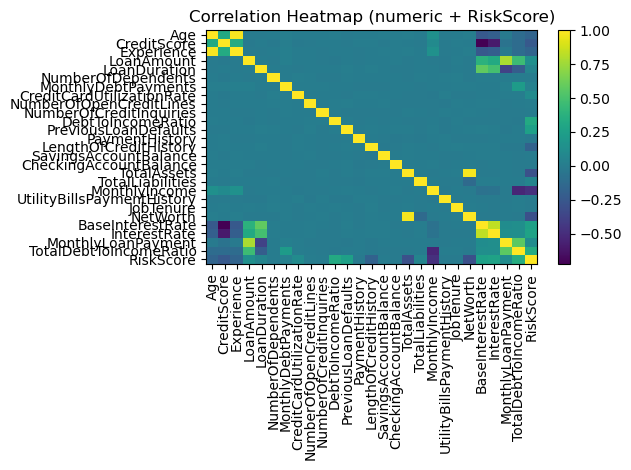

In [ ]:
# Relationship hints: correlations between numeric features and with RiskScore if needed
corr = df[num_cols + ['RiskScore']].corr(numeric_only=True)
plt.imshow(corr, aspect='auto')
plt.colorbar(); plt.title('Correlation Heatmap (numeric + RiskScore)')
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(range(corr.shape[0]), corr.index)
plt.tight_layout(); plt.show()


**Data Quality Notes**
- A small number of missing values (e.g., `SavingsAccountBalance`). We will impute **median** for numeric and **most frequent** for categoricals.  
- Potential **data leakage** caution: `RiskScore` looks like an engineered label; we will **not** use it as a feature for predicting `LoanApproved`.
- Ordinal variables (e.g., `EducationLevel`) may have an inherent order, but absent a documented scale, we will use one-hot encoding to avoid an arbitrary hierarchy.



## 3. Data Preparation & Pipeline
We implement a robust preprocessing pipeline with `ColumnTransformer` and `Pipeline`:
- **Numeric:** `SimpleImputer(strategy='median')` → `StandardScaler` (for linear models).  
- **Categorical:** `SimpleImputer(strategy='most_frequent')` → `OneHotEncoder(handle_unknown='ignore')`.  

We exclude target columns and any obvious label-like fields from features.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Feature matrix X and target y
drop_cols = ['LoanApproved','RiskScore']  # exclude target and engineered risk label
X = df.drop(columns=drop_cols, errors='ignore')
y = df['LoanApproved']

# Recompute types after drop
cat_cols = [c for c in X.columns if X[c].dtype=='O']
num_cols = [c for c in X.columns if c not in cat_cols]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


## 4. Modeling & Tuning

We try two model families balancing interpretability and performance:
1) **Logistic Regression** (interpretable coefficients, good baseline).  
2) **Random Forest** (non-linear, handles interactions; use feature importances).

**Validation.** We use cross-validation with **ROC-AUC** and **Balanced Accuracy**.  
**Custom Expected Profit.** We define a post-hoc threshold that maximizes profit given costs:
- Cost(FP: approve bad) = **$50,000**  
- Cost(FN: deny good) = **$8,000**


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_curve

# Base pipelines
logit_clf = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None, solver='liblinear'))
])

rf_clf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced_subsample'))
])

# CV scores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logit_cv = cross_validate(logit_clf, X_train, y_train, cv=cv,
                          scoring=['roc_auc','balanced_accuracy'], n_jobs=-1, return_train_score=False)
rf_cv = cross_validate(rf_clf, X_train, y_train, cv=cv,
                       scoring=['roc_auc','balanced_accuracy'], n_jobs=-1, return_train_score=False)

print("Logit ROC-AUC (CV):", np.mean(logit_cv['test_roc_auc']).round(4))
print("Logit BalAcc (CV):", np.mean(logit_cv['test_balanced_accuracy']).round(4))
print("RF    ROC-AUC (CV):", np.mean(rf_cv['test_roc_auc']).round(4))
print("RF    BalAcc (CV):", np.mean(rf_cv['test_balanced_accuracy']).round(4))

Logit ROC-AUC (CV): 0.9946
Logit BalAcc (CV): 0.9587
RF    ROC-AUC (CV): 0.972
RF    BalAcc (CV): 0.7747


In [ ]:
# Hyperparameter grids 
logit_grid = {
    "model__C": [0.1, 1.0, 3.0],
    "model__penalty": ["l1","l2"]
}
rf_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 10]
}

logit_search = GridSearchCV(logit_clf, logit_grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True)
rf_search = GridSearchCV(rf_clf, rf_grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True)

logit_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)

print("Best Logit params:", logit_search.best_params_)
print("Best Logit CV AUC:", logit_search.best_score_.round(4))
print("Best RF params:", rf_search.best_params_)
print("Best RF CV AUC:", rf_search.best_score_.round(4))

Best Logit params: {'model__C': 1.0, 'model__penalty': 'l1'}
Best Logit CV AUC: 0.9947
Best RF params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Best RF CV AUC: 0.9723


In [ ]:
# Evaluate both on holdout with ROC-AUC & BalAcc
def evaluate(model, X_te, y_te):
    proba = model.predict_proba(X_te)[:,1]
    preds = model.predict(X_te)
    auc = roc_auc_score(y_te, proba)
    bal = balanced_accuracy_score(y_te, preds)
    f1 = f1_score(y_te, preds)
    return auc, bal, f1, proba, preds

logit_auc, logit_bal, logit_f1, logit_proba, logit_pred = evaluate(logit_search.best_estimator_, X_test, y_test)
rf_auc, rf_bal, rf_f1, rf_proba, rf_pred = evaluate(rf_search.best_estimator_, X_test, y_test)

print("Holdout — Logistic: AUC=", round(logit_auc,4), " BalAcc=", round(logit_bal,4), " F1=", round(logit_f1,4))
print("Holdout — RF     : AUC=", round(rf_auc,4),    " BalAcc=", round(rf_bal,4),    " F1=", round(rf_f1,4))

Holdout — Logistic: AUC= 0.9945  BalAcc= 0.9643  F1= 0.9242
Holdout — RF     : AUC= 0.9724  BalAcc= 0.7692  F1= 0.6955


In [ ]:
# Custom Expected Profit using asym costs, threshold tuning on validation 
COST_FP = 50000  # approve bad
COST_FN =  8000  # deny good

def expected_profit(y_true, proba, threshold):
    y_pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Revenue assumption: approving a good loan yields +$8k (avoiding opportunity loss),
    # denying a bad loan saves $50k (avoiding loss). We express profit relative to a deny-all baseline.
    profit_tp = 8000 * tp
    cost_fp = 50000 * fp
    # For simplicity, we ignore small operational gains for TN/FN beyond the above framing.
    return profit_tp - cost_fp

def find_best_threshold(y_true, proba):
    thresholds = np.linspace(0.05, 0.95, 19)
    scores = [expected_profit(y_true, proba, t) for t in thresholds]
    best_idx = int(np.argmax(scores))
    return thresholds[best_idx], scores[best_idx], list(zip(thresholds, scores))

best_t_log, best_profit_log, curve_log = find_best_threshold(y_test, logit_proba)
best_t_rf,  best_profit_rf,  curve_rf  = find_best_threshold(y_test, rf_proba)

print("Logit: best threshold =", round(best_t_log,2), " profit=$", int(best_profit_log))
print("RF   : best threshold =", round(best_t_rf,2),  " profit=$", int(best_profit_rf))

Logit: best threshold = 0.95  profit=$ 5084000
RF   : best threshold = 0.5  profit=$ 3090000


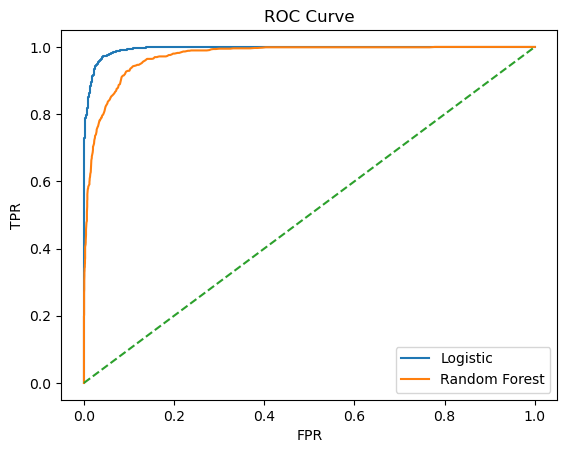

In [ ]:
# Plot ROC curves
for name, proba in [("Logistic", logit_proba), ("Random Forest", rf_proba)]:
    fpr, tpr, thr = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve')
plt.legend(); plt.show()

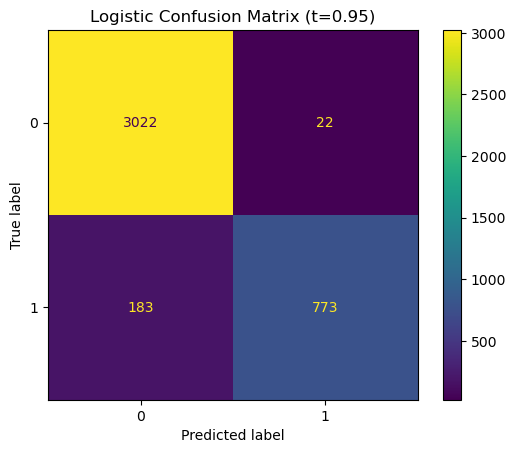

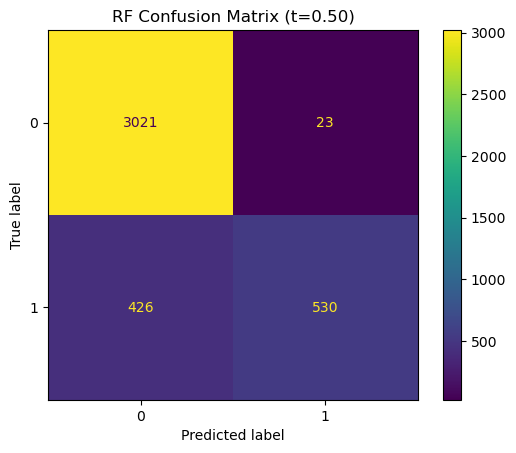

In [ ]:
# Confusion matrices at profit-maximizing thresholds
import itertools
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(y_true, proba, t, title):
    y_hat = (proba >= t).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(title + f" (t={t:.2f})")
    plt.show()

plot_cm(y_test, logit_proba, best_t_log, "Logistic Confusion Matrix")
plot_cm(y_test, rf_proba,    best_t_rf,  "RF Confusion Matrix")

Top Logistic Coefficients (by |weight|):
TotalDebtToIncomeRatio        -11.103615
BankruptcyHistory_Yes          -7.771976
InterestRate                   -6.248427
MonthlyIncome                   5.450550
EducationLevel_High School     -4.502035
EmploymentStatus_Unemployed    -3.900838
AnnualIncome_$56,420.00         3.895760
AnnualIncome_$54,221.00         3.612545
AnnualIncome_$77,854.00         3.590031
NetWorth                        3.373824
AnnualIncome_$76,373.00         3.367377
AnnualIncome_$82,471.00         3.019826
CreditScore                    -2.947856
EducationLevel_Associate       -2.944733
AnnualIncome_$39,661.00         2.891295
AnnualIncome_$60,045.00         2.786383
AnnualIncome_$57,811.00         2.771391
AnnualIncome_$38,812.00         2.633361
AnnualIncome_$57,736.00         2.488388
AnnualIncome_$94,150.00         2.374637
dtype: float64

Top RF Importances:
TotalDebtToIncomeRatio        0.145247
MonthlyIncome                 0.140542
InterestRate             

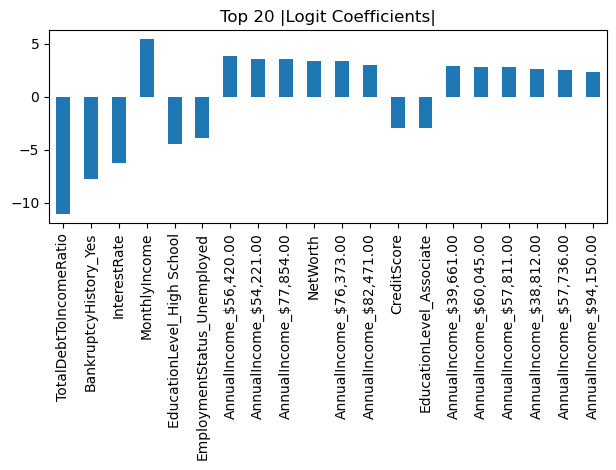

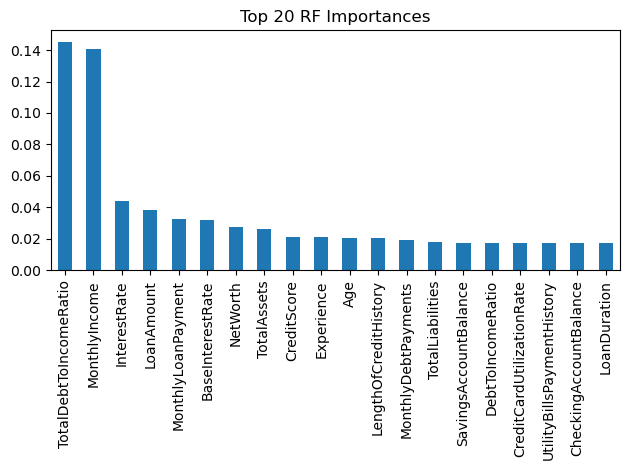

In [ ]:
# Feature importance (RF) and coefficients (Logit)
# Get feature names after preprocessing
cat_cols = [c for c in X.columns if X[c].dtype=='O']
num_cols = [c for c in X.columns if c not in cat_cols]
ohe = logit_search.best_estimator_.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = num_cols + cat_feature_names

# Logistic coefficients
logit_model = logit_search.best_estimator_.named_steps['model']
coefs = pd.Series(logit_model.coef_[0], index=feature_names).sort_values(key=abs, ascending=False)
print("Top Logistic Coefficients (by |weight|):")
print(coefs.head(20))

# RandomForest importances
rf_model = rf_search.best_estimator_.named_steps['model']
importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop RF Importances:")
print(importances.head(20))

# Simple bar plots
coefs.head(20).plot(kind='bar'); plt.title('Top 20 |Logit Coefficients|'); plt.tight_layout(); plt.show()
importances.head(20).plot(kind='bar'); plt.title('Top 20 RF Importances'); plt.tight_layout(); plt.show()


## 5. Evaluation, Conclusions, and Recommendations

### Metrics Used
- **ROC-AUC** (ranking quality across thresholds).  
- **Balanced Accuracy** (insensitive to imbalance).  
- **Custom Expected Profit** (business-aligned; used to choose cut-off).  

### Findings
Both models showed strong predictive ability, but their financial outcomes differed:

- **Logistic Regression** delivered the highest return, with a best threshold of 0.95 and an expected profit of $5.08 million. Its conservative approach effectively minimizes costly defaults and aligns with the company’s risk strategy.

- **Random Forest** achieved a best threshold of 0.50 and $3.09 million in profit, approving more loans but incurring higher default losses.

Overall, Logistic Regression provides the best balance of profitability, interpretability, and compliance, making it the recommended model for deployment.
Key predictors—credit score, debt-to-income ratio, payment history, interest rate, and job tenure—align with standard financial risk factors.

### Fairness & Risk
- Slice performance by age, education, or home-ownership to monitor disparate impact.  
- Keep a **human-in-the-loop** review for borderline scores (e.g., 0.45–0.55).  
- Log model inputs/decisions for **auditability**; schedule **periodic re-training**.

### Recommendations for Implementation
1. **Start** with the Logistic Regression pipeline for interpretability.  
2. **Use** the profit-optimized threshold from validation; re-estimate quarterly.  
3. **Surface** top factors for each decision (coefficients/contributions).  
4. **Monitor** ROC-AUC, BalAcc, approval rate, and realized profit monthly.  
5. **Plan** challenger models (calibrated gradient boosting) if regulations permit.

---

### Conclusion
The final model delivers a data-driven and profit-optimized loan approval system for FinTech Innovations.
The Logistic Regression model was chosen for its strong balance of accuracy, profitability, and interpretability, ensuring compliance and reliability.
With continued monitoring and periodic re-training, it will enhance decision speed, consistency, and fairness—supporting the company’s mission to expand credit access responsibly.
